# Project: Exploring Weather Trends

After some initial sampling via Udacity's SQL interface, I decided the simplest approach would be to dump the entire contents of the 3 tables into CSV files. With all the data available to me locally, I could load it into Pandas dataframes and continue my investigation on the command line. I thought this would also make it easier to complete the later steps in the project: calculating averages, generating visualizations, and publishing them in some readable format.

I began with some simple `SELECT *` statements, and saved the results as CSV files:

```
SELECT * FROM global_data;
SELECT * FROM city_data;
SELECT * FROM city_list;
```

With the data on hand, I loaded them into Pandas dataframes and saw what was there.

In [1]:
import pandas as pd

city_list = pd.read_csv('data/city_list.csv')
global_data = pd.read_csv('data/global_data.csv')
city_data = pd.read_csv('data/city_data.csv')

In [2]:
city_data.head()

,year,city,country,avg_temp
0,1849,Abidjan,Côte D'Ivoire,25.58
1,1850,Abidjan,Côte D'Ivoire,25.52
2,1851,Abidjan,Côte D'Ivoire,25.67
3,1852,Abidjan,Côte D'Ivoire,NaN
4,1853,Abidjan,Côte D'Ivoire,NaN


In [3]:
global_data.head()

,year,avg_temp
0,1750,8.72
1,1751,7.98
2,1752,5.78
3,1753,8.39
4,1754,8.47


In [262]:
city_list.head()

,city,country
0,Abidjan,Côte D'Ivoire
1,Abu Dhabi,United Arab Emirates
2,Abuja,Nigeria
3,Accra,Ghana
4,Adana,Turkey


## Initial Survey of Data

First, I wanted to take a look at what United States cities were included in the city list.

In [9]:
us_cities = city_list[ city_list.country=='United States' ].city
us_cities

8           Albuquerque
10           Alexandria
19            Arlington
23              Atlanta
24               Austin
27            Baltimore
46           Birmingham
48               Boston
66            Charlotte
69              Chicago
73     Colorado Springs
74             Columbus
81               Dallas
86               Denver
87              Detroit
96              El Paso
98           Fort Worth
102              Fresno
124             Houston
128        Indianapolis
134        Jacksonville
146         Kansas City
168           Las Vegas
176          Long Beach
178         Los Angeles
179          Louisville
199             Memphis
200                Mesa
202               Miami
204           Milwaukee
205         Minneapolis
221           Nashville
224         New Orleans
225            New York
229             Oakland
230       Oklahoma City
231               Omaha
243        Philadelphia
244             Phoenix
250            Portland
262             Raleigh
271          Sac

Interestingly, despite being the home of [the first Baptist church in America](https://en.wikipedia.org/wiki/First_Baptist_Church_in_America) and [the longest professional baseball game ever played](https://en.wikipedia.org/wiki/Longest_professional_baseball_game) and a state capital, my current residence of Providence, RI, is not included. I'll have to use Boston, MA, instead, and dream of the day when I might reside in a major metropolis like Wichita or Raleigh.

Some further exploration of the data shows that there are some name collisions between US cities and cities elsewhere around the globe:

In [5]:
city_data[ (city_data.city.isin(us_cities)) & (city_data.country != 'United States') ].groupby(['city','country']).size()

city         country       
Alexandria   Egypt             223
Birmingham   United Kingdom    271
Los Angeles  Chile             159
dtype: int64

Next, I counted the number of rows of data available for each US city. These range in size, meaning that there's different amounts of data points available for each city. That's something I'll have to keep in mind when doing the analysis.

For my own curiosity, I followed up by seeing how many cities are available for each country. The US, China, and India have the most data available, with a steep drop-off thereafter. If I want to do global comparisons, that will be something else to keep in mind.

In [7]:
city_data[ city_data.country=='United States' ].groupby(['city','country']).size()

city              country      
Albuquerque       United States    194
Alexandria        United States    271
Arlington         United States    271
Atlanta           United States    271
Austin            United States    194
Baltimore         United States    271
Birmingham        United States    271
Boston            United States    271
Charlotte         United States    271
Chicago           United States    271
Colorado Springs  United States    239
Columbus          United States    271
Dallas            United States    194
Denver            United States    239
Detroit           United States    271
El Paso           United States    189
Fort Worth        United States    194
Fresno            United States    165
Houston           United States    194
Indianapolis      United States    271
Jacksonville      United States    271
Kansas City       United States    256
Las Vegas         United States    179
Long Beach        United States    165
Los Angeles       United States 

In [8]:
city_list.groupby(['country']).size().reset_index(name='count').sort_values(['count'], ascending=False)[:20]

,country,count
130,United States,52
25,China,34
55,India,22
17,Brazil,11
93,Pakistan,9
101,Russia,9
79,Mexico,8
91,Nigeria,7
6,Australia,6
56,Indonesia,6


## Data Preparation

I begin by selecting the data available for the city of Boston. Looking at the first few rows, a couple of interesting points jump out. There are `NaN` values in the `avg_temp` column, which could throw off calculations for the moving average. Additionally, the first data available for Boston is from the year 1743. The global data starts from 1750. So, not only are there different quantities of data available for different locations, but the data could have different start and end dates, and include `NaN` values. This will all have to be accounted for in the analysis.

In [26]:
bos = city_data[ (city_data.city == 'Boston') & (city_data.country == 'United States') ]

In [27]:
bos.head()

,year,city,country,avg_temp
10457,1743,Boston,United States,1.19
10458,1744,Boston,United States,9.63
10459,1745,Boston,United States,-1.37
10460,1746,Boston,United States,NaN
10461,1747,Boston,United States,NaN


I dropped columns for `city` and `country` from the dataframe, since (by deisgn) they all have the same value. I used the `ffill` strategy for handling `NaN` values, propogating the previous valid value down through any `NaN` cells. This causes an unusually cold temperature to be copied from the year 1745 through 1749, but this seems like a reasonable approach. I then use Pandas built-in function for generating a moving average, `rolling`, and supply it with a window of 10, meaning 10 rows or 10 years.  

In [28]:
bos = bos.drop(columns=['city', 'country']).fillna(method='ffill')
bos['MA'] = bos['avg_temp'].rolling(window=10).mean()
bos.head(25)

,year,avg_temp,MA
10457,1743,1.19,NaN
10458,1744,9.63,NaN
10459,1745,-1.37,NaN
10460,1746,-1.37,NaN
10461,1747,-1.37,NaN
10462,1748,-1.37,NaN
10463,1749,-1.37,NaN
10464,1750,7.88,NaN
10465,1751,8.60,NaN
10466,1752,0.36,2.081


With the moving average saved on the dataframe, I can generate my initial visualization. I decided to include the `avg_temp` data as well, to get a better understanding of what's going on. Layering the data on top of each other, we see what we expect: volatile year-to-year data, and smoother moving-average data showing the overall trend.

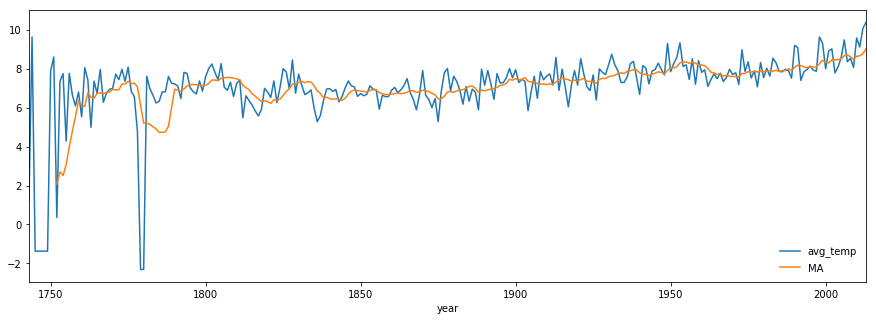

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]

lines = bos.plot.line(x='year').legend(loc='lower right', frameon=False)

## More Cities

The analysis of the Boston data looks good enough that I decide to replicate the process for several other US cities. I chose New Orleans, Chicago, and Los Angeles, since these sample a variety of locations across the country (plus I've lived in New Orleans and near Chicago).

The process is straightforward, but the data issues suggested by the Boston sample are present here as well: different start dates and sample sizes, with `NaN` values. In fact, the data for Los Angeles doesn't begin until a century later than the other cities. 

In [30]:
nola = city_data[ (city_data.city == 'New Orleans') & (city_data.country == 'United States') ]

In [31]:
nola.head()

,year,city,country,avg_temp
46085,1758,New Orleans,United States,20.87
46086,1759,New Orleans,United States,19.73
46087,1760,New Orleans,United States,9.24
46088,1761,New Orleans,United States,NaN
46089,1762,New Orleans,United States,NaN


In [32]:
nola = nola.drop(columns=['city', 'country']).fillna(method='ffill')
nola['MA'] = nola['avg_temp'].rolling(window=10).mean()
nola.head(25)

,year,avg_temp,MA
46085,1758,20.87,NaN
46086,1759,19.73,NaN
46087,1760,9.24,NaN
46088,1761,9.24,NaN
46089,1762,9.24,NaN
46090,1763,9.24,NaN
46091,1764,9.24,NaN
46092,1765,9.24,NaN
46093,1766,9.24,NaN
46094,1767,9.24,11.452


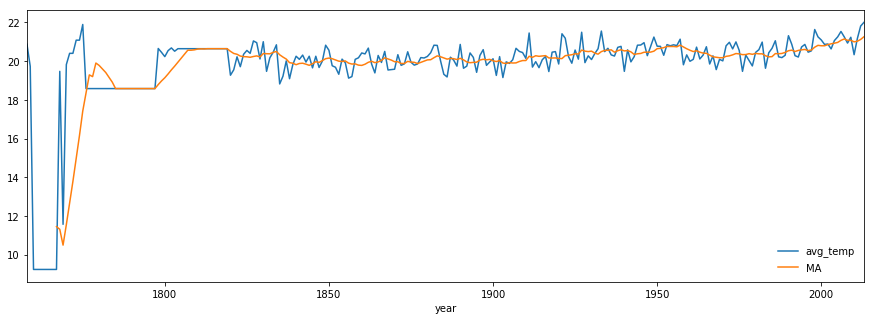

In [33]:
lines = nola.plot.line(x='year').legend(loc='lower right', frameon=False)

In [34]:
chi = city_data[ (city_data.city == 'Chicago') & (city_data.country == 'United States') ]
chi.head()

,year,city,country,avg_temp
15107,1743,Chicago,United States,5.44
15108,1744,Chicago,United States,11.73
15109,1745,Chicago,United States,1.80
15110,1746,Chicago,United States,NaN
15111,1747,Chicago,United States,NaN


In [35]:
chi = chi.drop(columns=['city', 'country']).fillna(method='ffill')
chi['MA'] = chi['avg_temp'].rolling(window=10).mean()
chi.head(25)

,year,avg_temp,MA
15107,1743,5.44,NaN
15108,1744,11.73,NaN
15109,1745,1.80,NaN
15110,1746,1.80,NaN
15111,1747,1.80,NaN
15112,1748,1.80,NaN
15113,1749,1.80,NaN
15114,1750,10.49,NaN
15115,1751,11.19,NaN
15116,1752,4.50,5.235


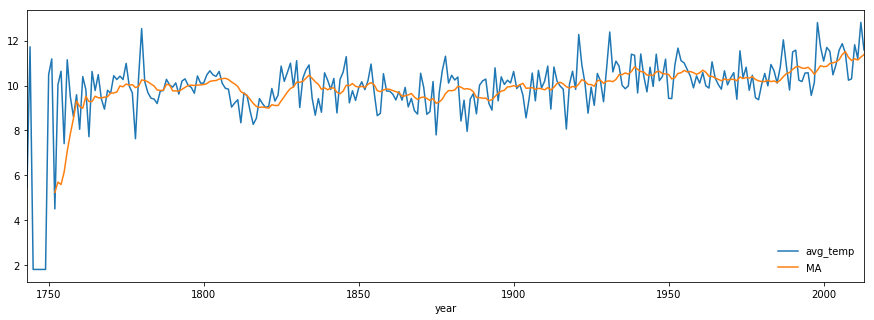

In [36]:
lines = chi.plot.line(x='year').legend(loc='lower right', frameon=False)

In [37]:
la = city_data[ (city_data.city == 'Los Angeles') & (city_data.country == 'United States') ]
la.head()

,year,city,country,avg_temp
36780,1849,Los Angeles,United States,15.71
36781,1850,Los Angeles,United States,15.28
36782,1851,Los Angeles,United States,15.53
36783,1852,Los Angeles,United States,15.61
36784,1853,Los Angeles,United States,16.27


In [38]:
la = la.drop(columns=['city', 'country']).fillna(method='ffill')
la['MA'] = la['avg_temp'].rolling(window=10).mean()
la.head(25)

,year,avg_temp,MA
36780,1849,15.71,NaN
36781,1850,15.28,NaN
36782,1851,15.53,NaN
36783,1852,15.61,NaN
36784,1853,16.27,NaN
36785,1854,15.74,NaN
36786,1855,15.94,NaN
36787,1856,15.52,NaN
36788,1857,16.19,NaN
36789,1858,15.67,15.746


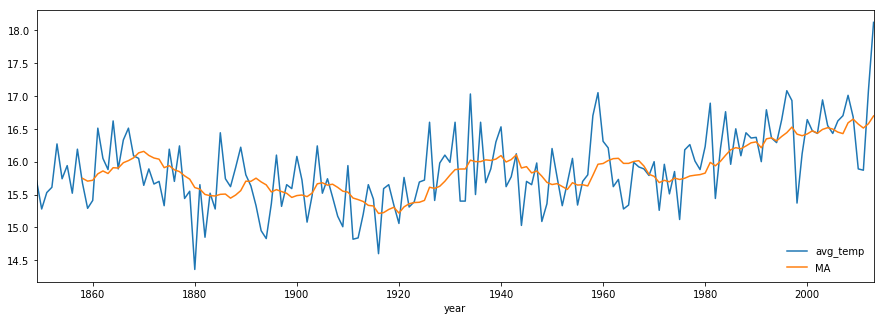

In [24]:
lines = la.plot.line(x='year').legend(loc='lower right', frameon=False)

## Data composition and visualization

I quickly gave the global data the same treatment, then set about the process of cleaning up and merging the data. I no longer needed the `avg_temp` data, so those columns are dropped from all the dataframes; and the `MA` column for each city is renamed to something appropriate for merge and comparison.

The combined dataframe will need a year range that encompasses all the data points. The earliest data is from 1743, so I set the range from 1740 to 2020 (presumably, there are no data points from the future). I then merged the other dataframes into the combined dataframe, joining on the `year` value.

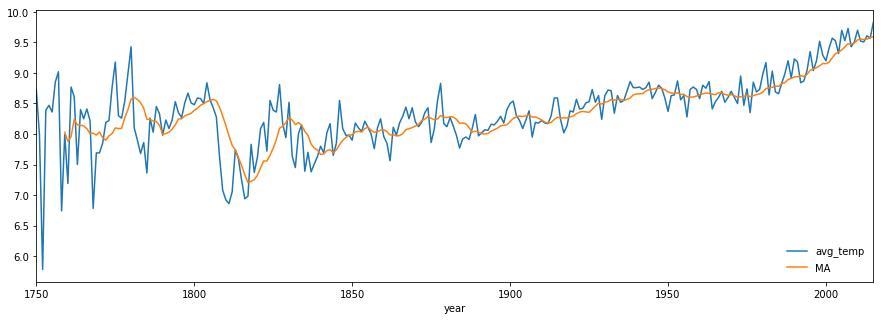

In [39]:
global_data = global_data.fillna(method='ffill')
global_data['MA'] = global_data['avg_temp'].rolling(window=10).mean()
lines = global_data.plot.line(x='year').legend(loc='lower right', frameon=False)

In [40]:
bos = bos.drop(columns=['avg_temp']).rename(columns={'MA': 'BOS'})
nola = nola.drop(columns=['avg_temp']).rename(columns={'MA': 'NOLA'})
chi = chi.drop(columns=['avg_temp']).rename(columns={'MA': 'CHI'})
la = la.drop(columns=['avg_temp']).rename(columns={'MA': 'LA'})
global_data = global_data.drop(columns=['avg_temp']).rename(columns={'MA': 'WORLD'})

cbd = pd.DataFrame({'year': [y for y in range(1740,2020) ]})
cbd = cbd.merge(bos, on='year', how='left')\
                .merge(chi, on='year', how='left')\
                .merge(nola, on='year', how='left')\
                .merge(la, on='year', how='left')\
                .merge(global_data, on='year', how='left')
cbd.head(20)

,year,BOS,CHI,NOLA,LA,WORLD
0,1740,NaN,NaN,NaN,NaN,NaN
1,1741,NaN,NaN,NaN,NaN,NaN
2,1742,NaN,NaN,NaN,NaN,NaN
3,1743,NaN,NaN,NaN,NaN,NaN
4,1744,NaN,NaN,NaN,NaN,NaN
5,1745,NaN,NaN,NaN,NaN,NaN
6,1746,NaN,NaN,NaN,NaN,NaN
7,1747,NaN,NaN,NaN,NaN,NaN
8,1748,NaN,NaN,NaN,NaN,NaN
9,1749,NaN,NaN,NaN,NaN,NaN


Finally, the data was ready for visualization and analysis. I adjusted the size of the graph vertically. Los Angeles and especially New Orleans are so much warmer than the other locations that it was effecting the scale. I also added a grid, which helps the eye locate the data points on the x-and y-axes.

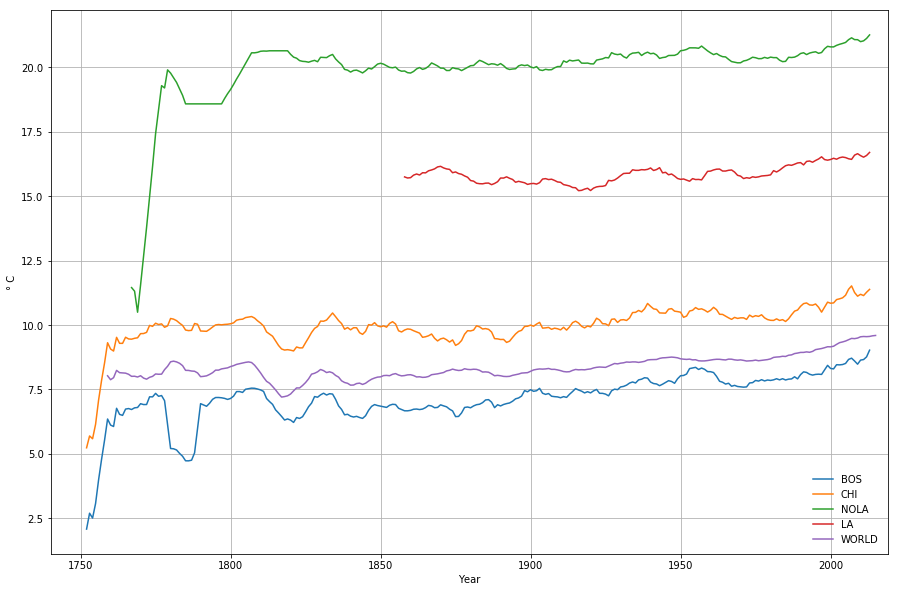

In [41]:
plt.rcParams['figure.figsize'] = [15, 10]

lines = cbd.plot.line(x='year', grid=True)
lines.legend(loc='lower right', frameon=False)
labels = lines.set(xlabel='Year', ylabel='\u00B0 C')

## Conclusions

